# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use linear regression with feature selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders (= # of features)
* Select the optimal features via cross-validation 
  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand position from the neural signals from the motor cortex.

We first load the basic packages.

In [70]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [71]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [72]:
#TODO
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

We extract two variables, `spikes` and `handPos`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand position.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handPos` data, we take the second component which is the position of monkey's hand.

In [73]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handPos'][0,:]

In [74]:
print(y0.shape)

(15536,)


The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [75]:
# TODO 
print("Number of Time Bins: {}".format(X0.shape[0]))
print("Number of Neurons: {}".format(X0.shape[1]))


Number of Time Bins: 15536
Number of Neurons: 196


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [76]:
time = mat_dict['time']
time = time[0]
time.shape
print("Number of Time Bins: {}".format(len(time)))
tsamp = np.mean(np.diff(time))
ttotal = np.sum(time)
print("Time between measurements: {}".format(tsamp))
print("Total duration of recording: {}".format(ttotal))

Number of Time Bins: 15536
Time between measurements: 0.05
Total duration of recording: 6229407.6895


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [77]:
# TODO
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X0, y0, test_size=0.5)

Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [78]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(Xtr, ytr)

LinearRegression()

Measure and print the normalized RSS on the test data.  

In [79]:
# TODO
ytest_pred = regr.predict(Xts)
RSS_test = np.mean((ytest_pred - yts)**2) / np.std(yts)**2
print("The Normalized RSS on the test data is {}".format(RSS_test))

The Normalized RSS on the test data is 8.020137959778081e+21


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

() (196,) (196,)


<ipython-input-80-f3ab07196809>:8: RuntimeWarning: invalid value encountered in true_divide
  Rsq = (sxy)**2/sxx/syy


Text(0, 0.5, 'The Coefficient of Determination')

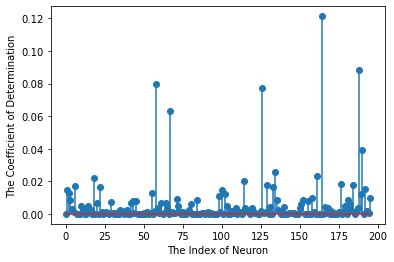

In [80]:
# TODO
xm = np.mean(X0, axis=0)
ym = np.mean(y0)
syy = np.mean((y0-ym)**2)
sxx = np.mean((X0 - xm[None,:])**2,axis=0)
sxy = np.mean((X0-xm[None,:]) * (y0[:,None]-ym),axis=0)
print(syy.shape, sxx.shape, sxy.shape)
Rsq = (sxy)**2/sxx/syy
plt.stem(Rsq)
plt.xlabel("The Index of Neuron")
plt.ylabel("The Coefficient of Determination")

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=50` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [81]:
d = 50  # Number of neurons to use

# TODO
Isel = np.argsort(Rsq)[:d]
print("The neurons with the ten highest R^2 values = {}".format(Isel[:10]))

The neurons with the ten highest R^2 values = [ 81  89 174 138  49 160  97 191 157  82]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [82]:
# TODO
Xnew = np.column_stack([X0[:,Isel[i]] for i in range(d)])
Xnew_tr, Xnew_ts = train_test_split(Xnew, test_size=0.5)

In [83]:
Xnew_tr.shape

(7768, 50)

In [84]:
new_regr = LinearRegression()
new_regr.fit(Xnew_tr, ytr)
ynew_hat_test = new_regr.predict(Xnew_ts)
RSS_new_test = np.mean((ynew_hat_test - yts)**2) / np.std(yts)**2
Rsq_new_tst = 1-RSS_new_test
print("RSS per sample = {0:f}".format(RSS_new_test))
print("R^2 =            {0:f}".format(Rsq_new_tst))

RSS per sample = 1.005117
R^2 =            -0.005117


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

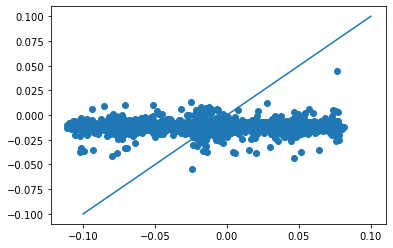

In [85]:
# TODO
plt.scatter(yts, ynew_test_pred)
plt.plot(np.linspace(-0.1, 0.1, 100), np.linspace(-0.1, 0.1, 100),'-')
plt.show()

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=50`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [86]:
import  sklearn.model_selection 

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
regr_kfold = LinearRegression()
# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)

RSS_kfold_test = np.zeros((nd, nfold))

for isplit, Ind in enumerate(kf.split(X0)):
    Itr, Its = Ind
    Xtr = X0[Itr]
    ytr = y0[Itr]
    Xts = X0[Its]
    yts = y0[Its]

    for it, d in enumerate(dtest):
        Isel_kfold = np.argsort(Rsq)[:d]
        Xtr_kfold = np.column_stack([Xtr[:,Isel_kfold[i]] for i in range(d)])
        Xts_kfold = np.column_stack([Xts[:,Isel_kfold[i]] for i in range(d)])
        regr.fit(Xtr_kfold, ytr)

        yhat_kfold = regr.predict(Xts_kfold)
        RSS_kfold_test[it, isplit] = np.mean((yhat_kfold - yts)**2)


print(RSS_kfold_test)

# TODO.  

[[1.89895653e-03 1.82321111e-03 1.89050940e-03 1.83510649e-03
  1.87883589e-03 1.85736719e-03 1.81151878e-03 1.75938961e-03
  1.87444541e-03 1.81158604e-03]
 [1.90194500e-03 1.82400485e-03 1.89193985e-03 1.83718588e-03
  1.88182978e-03 1.85906011e-03 1.81280750e-03 1.75990432e-03
  1.87736921e-03 1.81339024e-03]
 [1.90460533e-03 1.82856505e-03 1.89228729e-03 1.83925284e-03
  1.88548265e-03 1.86405992e-03 1.81373140e-03 1.76152151e-03
  1.87928684e-03 1.81493962e-03]
 [1.90764839e-03 1.82859184e-03 1.89201827e-03 1.83991163e-03
  1.88465333e-03 1.86933051e-03 1.81328494e-03 1.76453170e-03
  1.87951103e-03 1.82149921e-03]
 [1.90785792e-03 1.82776260e-03 1.89637589e-03 1.83889349e-03
  1.88812812e-03 1.86940512e-03 1.81247069e-03 1.76482928e-03
  1.88133831e-03 1.82337583e-03]
 [1.90864983e-03 1.82918592e-03 1.89638916e-03 1.83530170e-03
  1.88877932e-03 1.88053315e-03 1.81243878e-03 7.97343201e+19
  1.87831525e-03 1.82122661e-03]
 [1.90952783e-03 1.82390359e-03 1.89426358e-03 1.83629661e

Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

[1.84409264e-03 1.84594367e-03 1.84837325e-03 1.85009808e-03
 1.85104373e-03 7.97343201e+18 8.87086988e+16 1.48250933e+18
 1.19868764e+17 1.20904320e+18 5.44908531e+16 1.20213294e+18
 2.37278435e+16 1.98046862e+19 1.17259103e+19 2.66588808e+19
 2.89870381e+19 5.09486349e+18 4.45767159e+18]


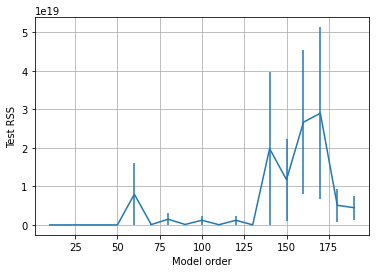

In [87]:
# TODO
RSS_mean = np.mean(RSS_kfold_test, axis=1)
print(RSS_mean)
RSS_std = np.std(RSS_kfold_test, axis=1)/np.sqrt(nfold-1)
plt.errorbar(dtest,RSS_mean, yerr=RSS_std, fmt='-')
plt.xlabel("Model order")
plt.ylabel("Test RSS")
plt.grid(True)

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [93]:
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]

# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
iopt = I[0]
dopt = dtest[iopt]

# Print results
print("The estimated model order is {}".format(dopt))
print("The test RSS per sample is {}".format(RSS_mean[iopt]))

The estimated model order is 10
The test RSS per sample is 9605601.398930965


## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.